# Lobsters
Let's imagine that you were a wildlife biologist studying lobsters, and you wanted to determine whether a given lobster would live or die.  What would you do?  The obvious answer would be to collect some data and see if there was a pattern of measurable variables with respect to which lobsters survived.  Fortunately, we have just such a dataset!  

In [1]:
#data

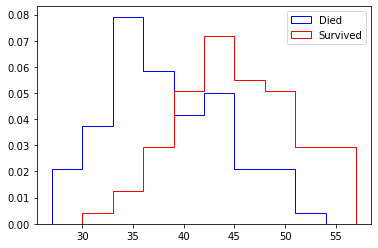

In [4]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('lobster_survive.dat',skiprows=1)
x,y = data.T

bins = np.unique(x)
plt.hist(x[y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(x[y==1],bins,histtype='step',density=True,label='Survived',color='red')
plt.legend()
plt.show()

We might like to know:
$$
P(\text{Survive}=1|\text{Length}=x),
$$
where $\text{Survive}$ is a variable indicating whether the lobster survived or not, and $\text{Length}$ is the length of the lobster ($x\in\mathcal{R}$).  Now we can use Bayes theorem to compute this probability directly
$$
P(\text{Survive}=1|\text{Length}=x) = \frac{P(\text{Length}=x|\text{Survive}=1)P(\text{Survive}=1)}{P(\text{Length}=x)}.
$$

First, we can fit a Bernoulli distribution to the prior distribution over the two classes
$$
P(\text{Survive}) = \text{Bernoulli}(\text{Survive};\theta).
$$

In [5]:
theta = y.mean() # compute theta of Bernoulli

In [6]:
theta

0.4968553459119497

then, we can fit a normal distribution to the length of both the "survived" and "died" classes using maximum likelihood estimation
$$
P(\text{Length}|\text{Survive}) = \mathcal{N}(Length;\mu_S,\sigma_S^2)
$$

In [7]:
def mean_normal(x):
    m = len(x)
    return x.sum()/m

def variance_normal(x,mu):
    m = len(x)
    return ((x-mu)**2).sum()/m

mu_0 = mean_normal(x[y==0])
mu_1 = mean_normal(x[y==1])
sigma2_0 = variance_normal(x[y==0],mu_0)
sigma2_1 = variance_normal(x[y==1],mu_1)

By the way, having computed these, we can look at the resulting probability density functions, or the bell curves applied to each of the Lobster classes

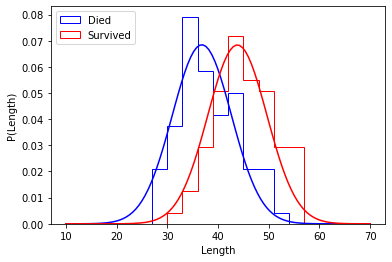

In [8]:
def likelihood(x,mu,sigma2):
    return 1./np.sqrt(2*np.pi*sigma2)*np.exp(-(x-mu)**2/(2*sigma2))

bins = np.unique(x)
plt.hist(x[y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(x[y==1],bins,histtype='step',density=True,label='Survived',color='red')

x_dense = np.linspace(10,70,101)
plt.plot(x_dense,likelihood(x_dense,mu_0,sigma2_0),'b-')
plt.plot(x_dense,likelihood(x_dense,mu_1,sigma2_1),'r-')
plt.legend()
plt.xlabel('Length')
plt.ylabel('P(Length)')
plt.show()


Finally, we can evaluate Bayes' theorem

In [9]:

def prior(theta):
    return theta

def evidence(x,mu_0,sigma2_0,mu_1,sigma2_1,theta):
    return likelihood(x,mu_1,sigma2_1)*prior(theta) + likelihood(x,mu_0,sigma2_0)*(1-prior(theta))

def posterior(x, mu_0, sigma2_0, mu_1, sigma2_1, theta):
    return likelihood(x,mu_1,sigma2_1)*prior(theta)/evidence(x,mu_0,sigma2_0,mu_1,sigma2_1,theta)

post = posterior(x_dense,mu_0,sigma2_0,mu_1,sigma2_1,theta)

We now have the posterior distribution for each of these data examples.  We can plot the posterior distribution, the probability of survival, as a function of length:

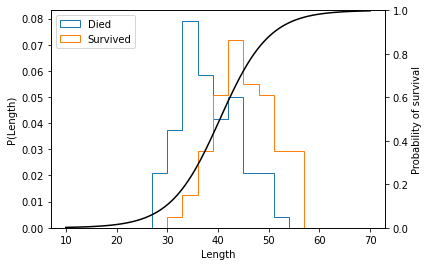

In [10]:
bins = np.unique(x)
plt.hist(x[y==0],bins,histtype='step',density=True,label='Died')
plt.hist(x[y==1],bins,histtype='step',density=True,label='Survived')
plt.legend()
plt.xlabel('Length')
plt.ylabel('P(Length)')
ax = plt.twinx()
ax.plot(x_dense,post,'k-',label='Probability of Survival')
ax.set_ylabel('Probability of survival')
ax.set_ylim(0,1)
#plt.legend()
plt.show()

A common next step is to apply a *threshold* in order to explicitly classify new lobsters into discrete classes, but this is just throwing away information: it's typically more interesting to know the relative probability of classes, so that you know for which cases there remains significant uncertainty.

# Mulitivariate Normal

## Multiple Classes, multiple features

All of our examples (both regression and classification) have been *univariate*: one feature on which to make predictions.  In a parallel way, the examples that we've looked at (binary classification and regression) are two endmembers of a spectrum: in binary classification, the prediction can be either positive or negative, while in regression the prediction can be any real number.  In practice, we'll want to relax all of these assumptions, so that we can use multiple features to classify objects into one of perhaps many classes.  Here's a dataset that will be useful to motivate this generalization:

Imagine that one day you’re happily working away at your job as a research florist, and your boss frantically
says to you: "I just got a call from the board of regents, who say that they’re willing to fully fund the floristry
department under one condition: that we can identify this species of iris that they’ve just sent us." Fortunately, we know a few things.  First, we've been informed that the species is definitely one of the following three species:  Iris setosa, Iris versicolor, or Iris virginica.  
<img src="images/iris_setosa.jpg" style="width: 400px;">

However, these irises look very similar, so we can’t tell just by looking. What should we do (with our department's financial solvency at stake)?  The reasonable answer is that you’re going to extract some data from
the iris, and compare it to data from a bunch of other irises with known species. And it just so happens that
we have access to a really nice database of flower metrics compiled by the very famous statistician [Ronald
Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher).  The dataset has four attributes: petal length, petal width, sepal length, and sepal width. (By the way [sepals](https://en.wikipedia.org/wiki/Sepal) are the leaves that surround the flower. Let’s take a look at what these features look like.  Because this dataset is so famous and useful as a benchmark, it's available in python's scikit-learn package.

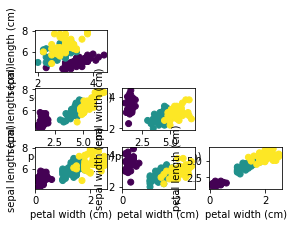

In [2]:
from sklearn import datasets  # Import the sklearn datasets module
import matplotlib as mpl      # Plotting tools
mpl.rcParams['figure.figsize'] = [18,15]
mpl.rcParams['font.size'] = 18
import matplotlib.pyplot as plt

#Load the dataset
iris = datasets.load_iris()
x = iris.data 
y = iris.target

#Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica
classes = [0,1,2] 

N = len(classes) # The number of classes
m = x.shape[0]   # The number of data points
n = x.shape[1]   # The number of features

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 = 3 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
fig.subplots_adjust(hspace=0.4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(x[:,i],x[:,j],c=y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()

In [3]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
def one_hot(y):
    N = len(np.unique(y))
    m = len(y)
    z = np.zeros((m,N))
    for i in range(m):
        z[i,y[i]] = 1
    return z
z = one_hot(y)

Our goal is to take a new set of iris measurements and output a class (an iris species).  We can use a similar procedure as the one we used above to make a classification.  Indeed the math looks pretty similar
$$
P(\text{Species}=z|\mathbf{X}=\mathbf{x}) = \frac{P(\mathbf{X}=\mathbf{x}|\text{Species}=z) P(\text{Species}=z)}{P(\mathbf{X}=\mathbf{x})}.
$$
For brevity, I'm going to write this as 
$$
P(Z=z|\mathbf{X}=\mathbf{x}) = \frac{P(\mathbf{X}=\mathbf{x}|Z=z)P(Z=z)}{P(\mathbf{X}=\mathbf{x})},
$$
where $Z$ is a one-hot encoding of the species and $\mathbf{X}$ is the data (sepal length, sepal width, etc.).  Once again, we have a prior that quantifies the probability that a new example is of a given species *prior* to looking at its features, a *likelihood* that tells us how likely it is that we would have observed the features that we did if the iris is of a given species, and the evidence which ensures that all the probabilities of the different classes add up to 1. 

There are a few differences though.  First is in how we want to model the prior $P(Z=z)$.  Before, we were able to use the Bernoulli distribution which gives the probability of successes, with a single parameter $\theta$.  However, we can't use that here.  **Why not?**  

Instead, we will use a very closely related distribution called the *Categorical distribution*, which is simply
$$
P(Z=z|\boldsymbol{\theta}) = \prod_{k=1}^N \theta_k^{z_k}
$$
where $C_k$ is the $k-th$ class in a set of $N$ possibilities (e.g. $C_k\in[\text{Virginica},\text{Versicolor},\text{Setosa}]$) and$\theta_k$ is the probability of that class.  Because we assume that the species *has* to be one of these possibilites
$$
\sum_{k=1}^N \theta_k = 1.
$$
At first glance, this looks a bit different from the Bernoulli distribution, but its actually just a generalization.  To see this, let's set $N=2$ (a binary problem), which gives
$$
P(Z=z|\theta_1,\theta_2) = \theta_1^{z_1} \theta_2^{z_2},
$$
Now, if we use the constraint that $\theta_2 = 1-\theta_1$
$$
P(Y=y|\theta_1) = \theta_1^{z_1} (1-\theta)^{1-z_1},
$$
which is just the Bernoulli distribution we saw before.  For a uniform prior on $\theta$, we can compute the MAP value for $\boldsymbol{\theta}$ easily, using the same methods that we did for the Bernoulli and normal distribution, and we get
$$
\theta_k = \frac{\sum_{i=1}^m z_k}{m},
$$
or "the number of training data that were of a given species, divided by the total number of training data".

**Fit a categorical distribution to the iris dataset (Note especially that this has nothing to do with the features yet.**

In [13]:
theta = np.sum(z,axis=0)/len(z)
print(theta)

[0.33333333 0.33333333 0.33333333]


The second change we need to make is to adapt our machinery to allow for multiple features.  The features in this case show up in the *likelihood*
$$
P(\mathbf{X}=\mathbf{x}|Z=z).
$$
$\mathbf{x}$ is now a vector, and that means that the likelihood is a now a multidimensional distribution.  **In the case of the iris dataset, what is its dimensionality?** 

One way of dealing with this is to use a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution), which is given by
$$
P(\mathbf{X}=\mathbf{x}|\boldsymbol{\mu},\Sigma) = (2\pi)^{-\frac{k}{2}} \text{det}(\Sigma)^{-\frac{1}{2}}\exp \left[-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right],
$$
where $\boldsymbol{\mu}$ is a *vector* of means (one for each dimension in the data), and $\Sigma$ is a matrix called the *covariance*.  Despite it looking a little bit scary, this thing actually isn't so bad: it just generalizes the bell curve to two dimensions, so that instead of normally distributed variables looking like this:

(array([  1.,   0.,   3.,   9.,  13.,  42.,  59.,  90., 138., 140., 144.,
        132., 102.,  52.,  36.,  19.,  12.,   5.,   1.,   2.]),
 array([-3.51362423, -3.16140791, -2.80919158, -2.45697525, -2.10475893,
        -1.7525426 , -1.40032627, -1.04810995, -0.69589362, -0.34367729,
         0.00853903,  0.36075536,  0.71297169,  1.06518802,  1.41740434,
         1.76962067,  2.121837  ,  2.47405332,  2.82626965,  3.17848598,
         3.5307023 ]),
 <BarContainer object of 20 artists>)

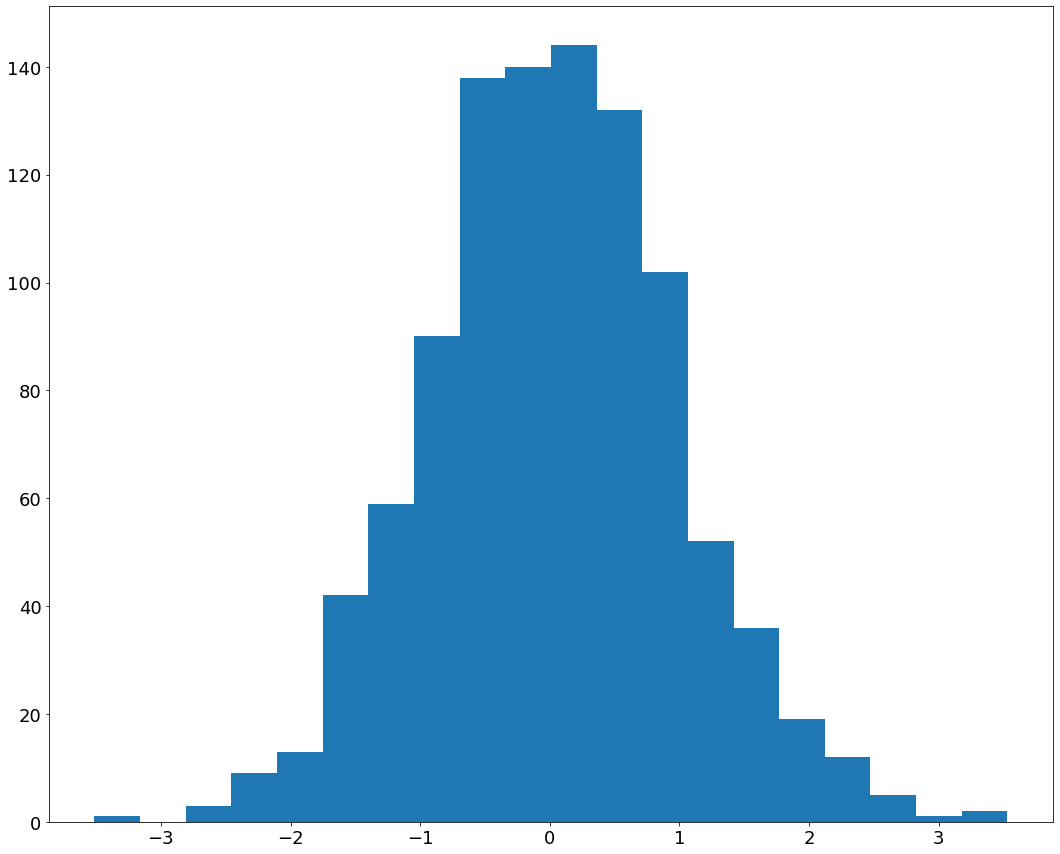

In [14]:
plt.hist(np.random.randn(1000),20)

In two dimensions, it looks like this:

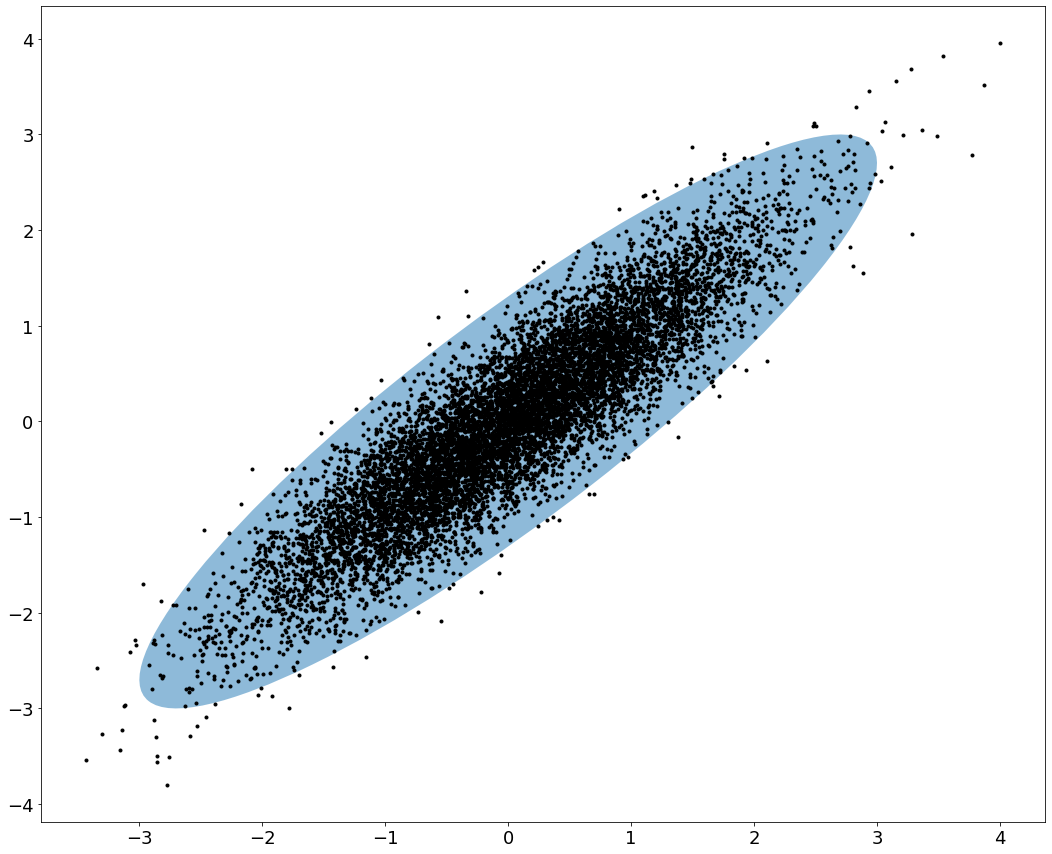

In [15]:
from matplotlib.patches import Ellipse  
def cov_ellipse(mu_k, Sigma_k, ax):
    # Plots the 3-sigma credible countour for a given multivariate normal distribution.  
    
    # How does this work?  (think about PCA).
    w,v = np.linalg.eig(Sigma_k)
    ellipse = Ellipse(mu_k, width=3*np.sqrt(w[0]) * 2, height=3*np.sqrt(w[1]) * 2, angle=np.rad2deg(np.arccos(v[0,0])),alpha=0.5)
    return ax.add_patch(ellipse)


Sigma = np.array([[1,0.9],
                  [0.9,1]])
A = np.linalg.cholesky(Sigma)
X = A @ np.random.randn(2,10000) 
X = X.T
plt.plot(X[:,0],X[:,1],'k.')
cov_ellipse(np.zeros((2)),Sigma,plt.gca())
plt.show()

Where if we took a in either dimension, it would look like a bell curve.

Nonetheless, using this full distribution is challenging because of $\Sigma$: it's a (symmetric) matrix in $\mathcal{R}^{n\times n}$, and as such has $\mathcal{O}(n^2)$ parameters that we would need to infer.  As the number of features in our dataset grows large (as it will for, say, image data), this will become prohibitive.  

In order to keep the number of parameters reasonable, we will use the so-called *naive* assumption, which states that all of the features are *independent*.  In the case of the iris, this means that we assume that, for example, the sepal width and sepal length are uncorrelated.  **Looking back at these data, does this seem like a good assumption?**

Regardless of whether its valid or not, it is very helpful to be able to say that
$$
P(\mathbf{X}=\mathbf{x}) \approx \prod_{j=1}^n P(X_j=x_j).
$$
If $P(X_j=x_j)$ are univariate normal distributions, then now there is simply two parameters for each feature (for each class): one mean and one variance.  Note that if we're conditioning these features on the classes, we can write the distribution as 

$$
P(\mathbf{X}=\mathbf{x}|Z=z) = \prod_{k=1}^N \prod_{j=1}^n \mathcal{N}(\mathbf{x}_j;\mu_{jk},\sigma^2_{jk})^{z_k}.
$$

Again, the maximum likelihood estimator for the parameters $\mu_{jk}$ and $\sigma^2_{jk}$ are intuitive and easy to compute: just the means and variances for the $j$-th feature restricted to the $k$-th class: 

These end up being straightforward to compute:
$$
\mu_{jk} = \frac{\sum_{i=1}^m x_{ij} z_{ik}}{\sum_{i=1}^m z_{ik}},
$$
$$
\sigma^2_{jk} = \frac{\sum_{i=1}^m (x_{ij} - \mu_{jk}) z_{ik}}{\sum_{i=1}^m z_{ik}},
$$
To be clear, $j$ indexes the feature of interest (petal length, sepal length, etc.) while $k$ indexes the class (virginica, setosa, etc.).  Put in words, the above formulas state: take your training data, split it by observed class and by the feature that you're interested in.  Then, take the sample mean and sample variance of each of these splits. 

To be clear, what we want to do is to fit a normal distribution to *each* histogram in each of these four plots:

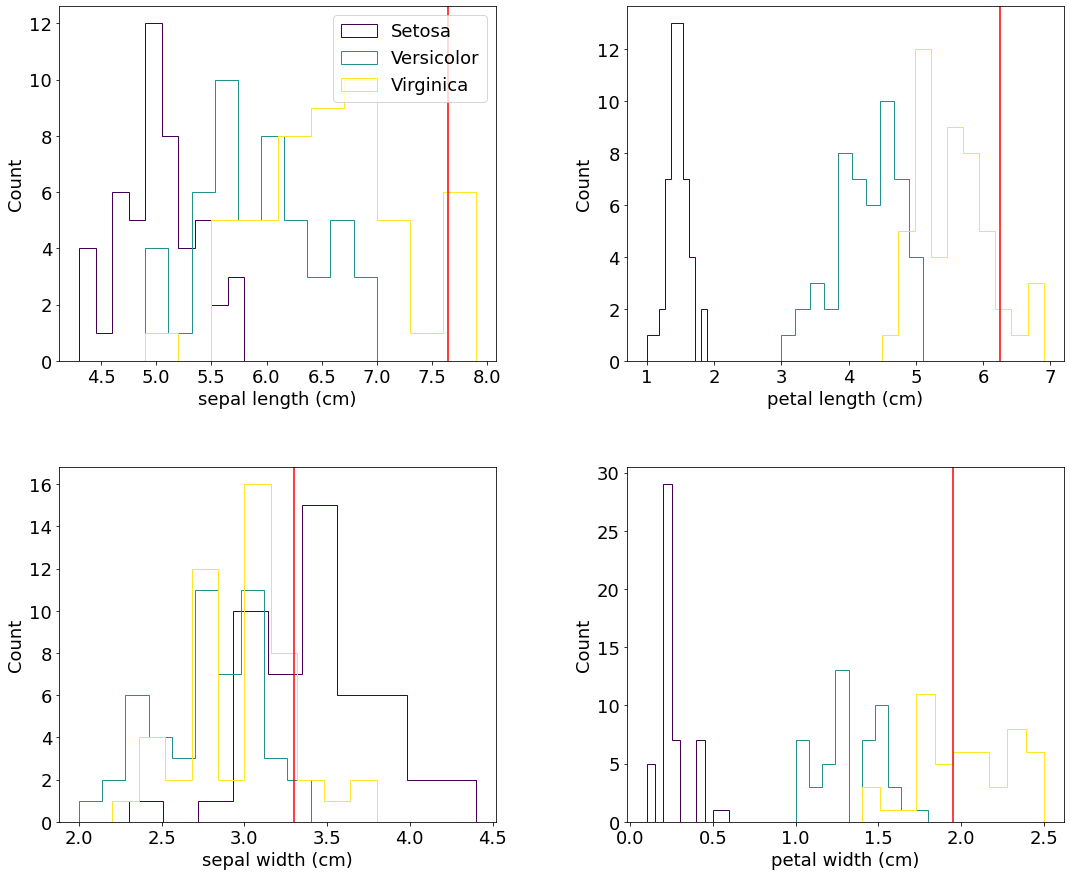

In [16]:
# Colors for each class
colors = [[0.267004, 0.004874, 0.329415, 1.      ],
          [0.127568, 0.566949, 0.550556, 1.      ],
          [0.993248, 0.906157, 0.143936, 1.      ]]
names = ['Setosa','Versicolor','Virginica']

x_new = np.array([7.65, 3.3 , 6.25, 1.95])

# Plot histograms of all the features
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(4):
    p = i%2
    q = i//2
    axs[p,q].hist(x[y==0,i],histtype='step',color=colors[0],label=names[0])
    axs[p,q].hist(x[y==1,i],histtype='step',color=colors[1],label=names[1])
    axs[p,q].hist(x[y==2,i],histtype='step',color=colors[2],label=names[2])
    axs[p,q].axvline(x_new[i], color='red')
    axs[p,q].set_xlabel(iris.feature_names[i])
    axs[p,q].set_ylabel('Count')
axs[0,0].legend()
plt.show()

For a new example (the red line), we'll ask: "which of these classes are the features of this new example consistent with?" We'll multiply these with each other then by the prior likelihood of each of these classes (are some irises extremely rare?), and this will tell us the relative probability of each iris species.  

## IC Fitting irises
With this material in place, you are now ready to train and test a naive Bayes classifier on the iris dataset.  The first step is to compute and store the values of $\theta$ for each class, and the values of $\mu$ and $\sigma^2$ for each feature and each class.  Do this for a randomly selected training set (already split for you below).

In [17]:
import sklearn.model_selection as ms
x_train,x_test,z_train,z_test = ms.train_test_split(x,z)

In [18]:
mus = np.zeros((n,N))
denominator = np.zeros((n,N))
for j in range(n):
    for k in range(N):
        for i in range(len(z_train)):
            mus[j,k] += z_train[i,k]*x_train[i,j]
            denominator[j,k] += z_train[i,k]

mus /= denominator

sigmas = np.zeros((n,N))
for j in range(n):
    for k in range(N):
        for i in range(len(z_train)):
            sigmas[j,k] += z_train[i,k]*(x_train[i,j] - mus[j,k])**2
            
sigmas /= denominator 


Next, compute the posterior probability of each class for each test set example.  You can simplify this by ignoring the *evidence* (the denominator in Bayes theorem), and simply classifying based on which of the resulting *unscaled* posterior probabilities is greatest.  **Why is it okay to ignore the evidence in this case?**  Make a scatter plot with both the training and test data, colored by iris species but with different symbols to indicate whether a given example comes from the test or training set.  

In [22]:
# Want to classify 

#P(Y=C_0|X=x) = P(X=x|Y=C_0) P(Y=C_0) / evidence
# P(X=x|Y=C_0) = prod P(X_i=x_i | C_k)

x_new = x_test[0]

def normal(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x-mu)**2/sigma**2)

def unscaled_posterior(x):
    posteriors = np.array([1.,1,1])
    for k in range(N):   
        prior = theta[k]
        likelihood = 1
        for j in range(n):
            likelihood *= normal(x_new[j],mus[k,j],sigmas[k,j])
        posteriors[k] *= prior*likelihood
    return posteriors

unscaled_prob = unscaled_posterior(x_new)
evidence = unscaled_prob.sum()
posteriors = unscaled_prob/evidence

print(posteriors)

IndexError: index 3 is out of bounds for axis 1 with size 3

# The origin of the normal distribution (A simulation aside)
The normal distribution shows up in many places.  One common theme is for observational error to be modelled as normal distribution.  As you'll see, if you've ever done linear regression you've used this assumption.  Blood pressure is normally distiributed, as are height and weight within a species.  Why is it ubiquitous and so commonly used as a model for things?  The short answer is [the central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), which essentially states that if a large number of independent random effects are added together, the resulting sum is approximately normally distributed.  For example, if we're using a GPS, and repeatedly measuring the time that it takes for a satellite to send a signal to us, those measurements tend to be normally distributed, because there are a large number of random things that happen to the radio wave between when it leaves the satellite and when it gets to us.  The key thing here is that it matters very little how those intermediate features are distributed: as long as they are random and independent, their resulting cumulative effect will still be normal.  

As a short and sort of interesting in-class exercise, I'd like you to model this process for height.  Let's assume an approximate genetic model for height, in which height is controlled by $n$ distinct genes.  Each gene influences height by adding between -5 and +5 cm to a person's height.  As such, you should construct an array of $n$ gene effects, with each entry being drawn from
$$
P(\text{Gene Effect}_k) = \mathrm{UniformInteger}(-5,5).
$$
This array should remain fixed across the population.  Now, we'd like to simulate a population of humans.  Assume a mean height of 170 cm.  Then, for a particular person, a particular gene may be present or absent, and this presence or absence is given by a Bernoulli random variable with $\theta=0.5$.
$$
P(\text{Has Gene i}|\text{Person j}) = \text{Bernoulli}(\theta=0.5).
$$

A person's height is then given by
$$
H_j = \text{Mean Height} + \sum_{i=1}^n (\text{Has Gene i | Person j}) \times \text{Gene Effect i}.
$$

Generate a random sample of 10000 heights according to the above model and with $n\in\{1,5,10,100,1000\}$.  Plot histograms of these populations.  Evaluate the shape that emerges as $n$ becomes large.  



In [20]:
import numpy as np
population_size = 10000
n = 100
mean = 170
population = []

for p in range(population_size):
    height = mean
    for g in range(n):
        gene_effect = np.random.choice(np.linspace(-5,5,11))
        has_gene = np.random.choice([0,1])
        height += has_gene*gene_effect
    population.append(height)

(array([1.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 2.000e+01, 5.700e+01,
        1.020e+02, 2.310e+02, 3.740e+02, 5.690e+02, 8.880e+02, 1.049e+03,
        1.375e+03, 1.282e+03, 1.188e+03, 1.069e+03, 6.980e+02, 5.310e+02,
        2.710e+02, 1.380e+02, 9.400e+01, 3.500e+01, 1.300e+01, 2.000e+00,
        2.000e+00]),
 array([ 72. ,  79.4,  86.8,  94.2, 101.6, 109. , 116.4, 123.8, 131.2,
        138.6, 146. , 153.4, 160.8, 168.2, 175.6, 183. , 190.4, 197.8,
        205.2, 212.6, 220. , 227.4, 234.8, 242.2, 249.6, 257. ]),
 <BarContainer object of 25 artists>)

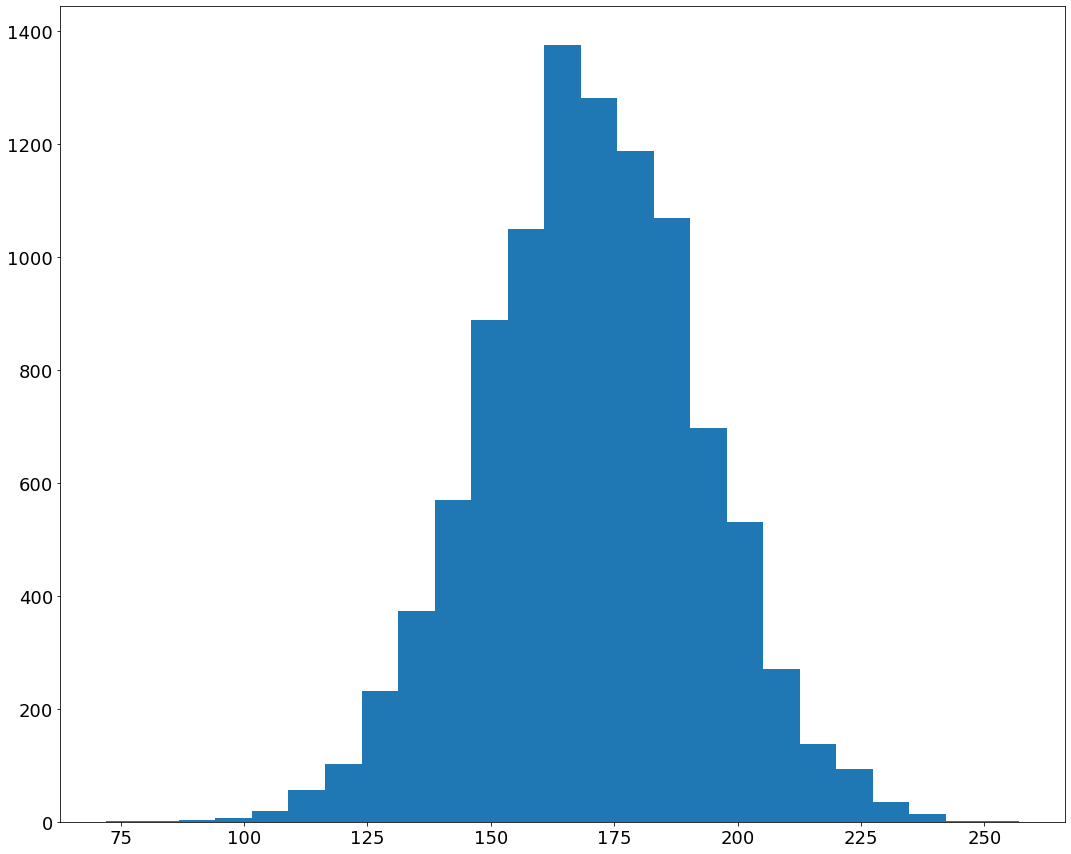

In [21]:
import matplotlib.pyplot as plt

plt.hist(population,25)